# Исследование сервиса аренды самокатов GoFast

Сервисом аренды самокатов GoFast были передоставленные данные о пользователях из разных городов, их поездках, а также типе подписки. Требуется провести их исследование и сделать выводы, которые могут помочь бизнесу в итоге получить больше выручки.

Выручка зависит от типа подписки клиентов. Клиенты с подпиской платят месячную подписку 199р и за каждую минуту поездки - 6 рублей. Клиенты без подписки плятат 50 рублей за старт поездки  и 8 рублей за минуту поездки. 

**Цели исследования** 

Проверить три гипотезы продакт-менеджеров:
- клиенты с подпиской тратят больше времени на поездки, 
- расстояние поездок клиентов с подпиской меньше 3130 метров 
- помесячная выручка от таких клиентов больше 

Выполнить расчеты по задачам отдела маркетинга
- Сколько надо разослать прокодов
- Сколько push-уведомлений будут открыты

**Ход исследования** 

Данные представлены в трех датасетах - users_go.csv,  rides_go.csv и subscriptions_go.csv - о пользователях, поездках и типах подпискок соотвественно. О качестве данных ничего не известно, поэтому перед основным исследованием потребуется обзор данных. Надо проверить даные на ошибки. Если они есть, надо найти возможность исправить некорректные данные.

Таким образом, исследоваание будет состоять из восьми этапов:

- Загрузка данных
- Преобработка данных
- Исследовательский анализ данных
- Формирование датасетов для расчета выручки
- Подсчет выручки клиентов разных типов
- Проверка гипотез
- Расчеты по задачам отдела маркетинга
- Общий вывод

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Хорошо. Модули выгружены

## Шаг 1. Загрузка данных

Загружаем три исходных датасета

In [2]:
try: 
    users = pd.read_csv('d:/practicum/4sprint/users_go.csv')
    rides = pd.read_csv('d:\practicum/4sprint/rides_go.csv')
    subscriptions = pd.read_csv('d:/practicum/4sprint/subscriptions_go.csv')
except:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

Первичная оценка датасетов

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


***Промежуточный итог***  
Загрузили данные в три датасета. Предварительно, датасеты не содержат пропусков. Типы данных, кроме даты - корректные. Название колонок - корректные.

## Шаг 2. Предобработка данных

Проверяем на дубликаты

In [9]:
users.duplicated().sum()

31

In [10]:
rides.duplicated().sum()

0

В датасете users есть 31 дубликат. Оценим их:

In [11]:
users[users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Данные в дубликатаъ разные, однако можно заметить, что индексы строк с дубликами идут последовательно, начиная с 1534. Можно предположить, что их специально добавили для этого задания =) Удаляем дубликаты и сбросываем индексы.

In [12]:
users = users.drop_duplicates().reset_index(drop=True)

Еще раз смотрим датасет users

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.1+ KB


Преобразуем в датасете rides колонку date к типу DateTime

In [14]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [15]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Оценим минимальное и максимальное значение колонки date

In [16]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [17]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Датасет rides содержит данные о поездках с 1 января по 29 декабря 2021 года

Создадим в датасете rides колонку month, в которой будет месяц поездки, полученный из даты

In [18]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

Еще раз смотрим датасет rides

In [19]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


***Промежуточный итог***  
В ходе предобработки в исходном датасете users были убраны дубликаты, а в датасете rides исправлен типа данных DateTime.

## Шаг 3. Исследовательский анализ данных

Оценим распределение клиентов по городам

In [20]:
users.groupby('city')['city'].count().sort_values()

city
Москва            168
Тюмень            180
Омск              183
Сочи              189
Краснодар         193
Ростов-на-Дону    198
Екатеринбург      204
Пятигорск         219
Name: city, dtype: int64

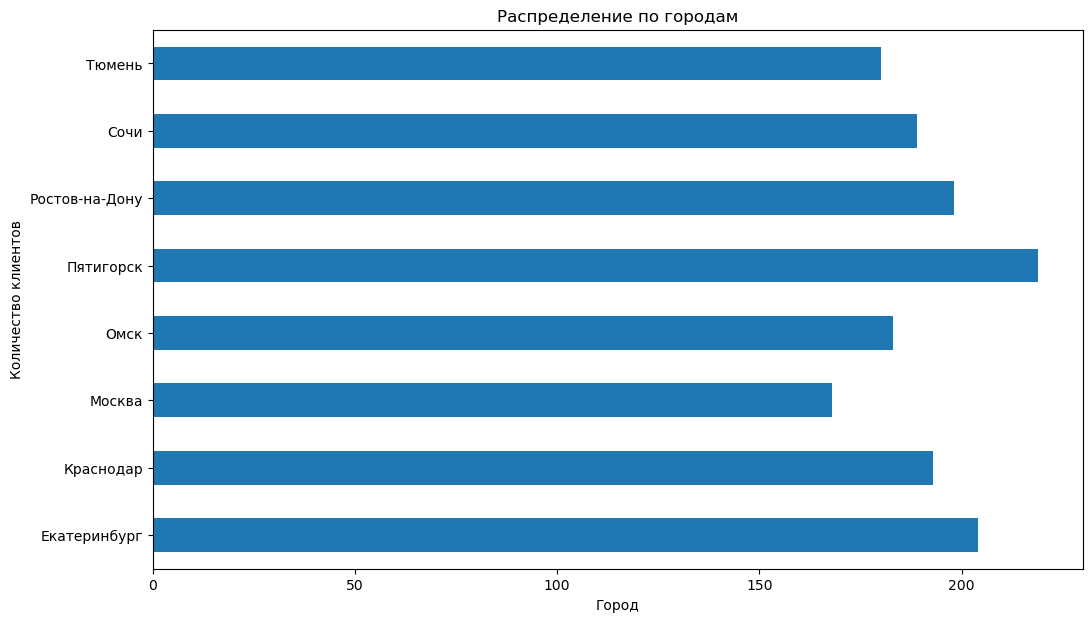

In [21]:
users.groupby('city')['city'].count().plot(kind='barh', x='city', y='count', figsize = (12, 7));
plt.title('Распределение по городам')
plt.ylabel('Количество клиентов')
plt.xlabel('Город')
plt.show()

Из графика видно, что у сервиса GoFast больше всего клиентов в Пятигорске (219), а меньше всего - в Москве (168)

Оценим, сколько клиентов имеют подписку, а сколько пользуются самокатами без подписки.

In [22]:
users.groupby('subscription_type')['subscription_type'].count()

subscription_type
free     835
ultra    699
Name: subscription_type, dtype: int64

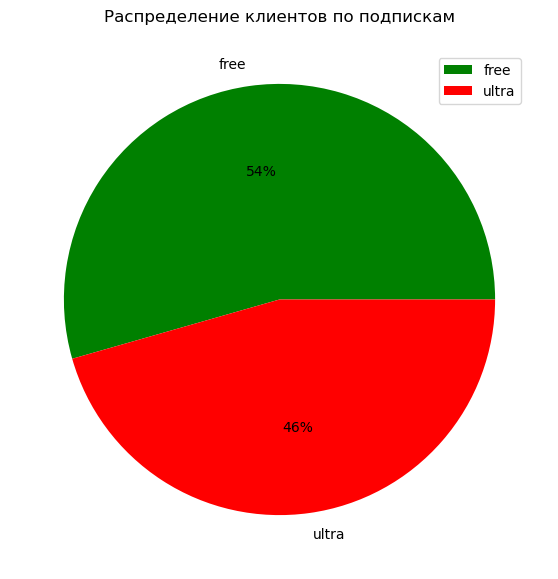

In [23]:
users.groupby('subscription_type')['subscription_type'].count().plot(kind='pie', y='count', \
        autopct='%1.0f%%', colors = ['green', 'red'], figsize = (7, 7), legend=True);
plt.title('Распределение клиентов по подпискам')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), borderaxespad= 2)
plt.ylabel('')
plt.show()

Из диаграммы видно, что соотношение клиентов с подпиской и без - 46% на 54%. Подписчиков меньше (699), чем клиентов без подписки (835)

### Возраст пользователей сервиса GoFast

Оценим возраст клиентов сервиса GoFast

In [24]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

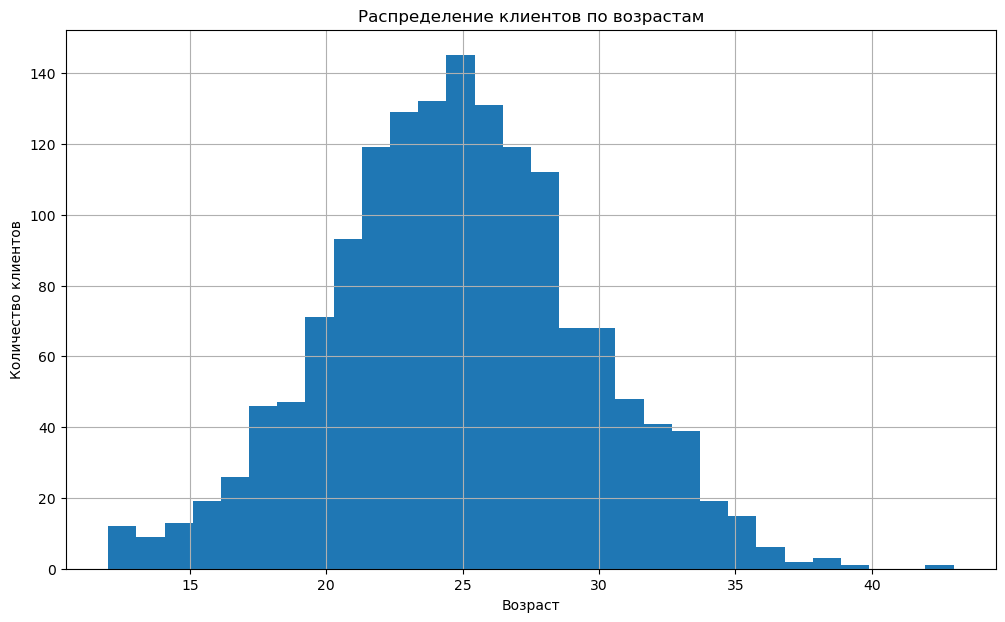

In [25]:
users['age'].hist(bins=30, figsize = (12, 7));
plt.title('Распределение клиентов по возрастам')
plt.ylabel('Количество клиентов')
plt.xlabel('Возраст')
plt.show()

Больше всего клиентов сервиса в возрасте 25 лет, но есть и 43-летние и 12-летние любители самокатов. В целом распределенеи клиентов по возрасту нормальное.

### Продолжительность одной поездки

Оценим продолжительность одной поездки всех клиентов сервиса GoFast

In [26]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Средняя поездка длится почти 18 минут. Средняя и медианная - практически равны

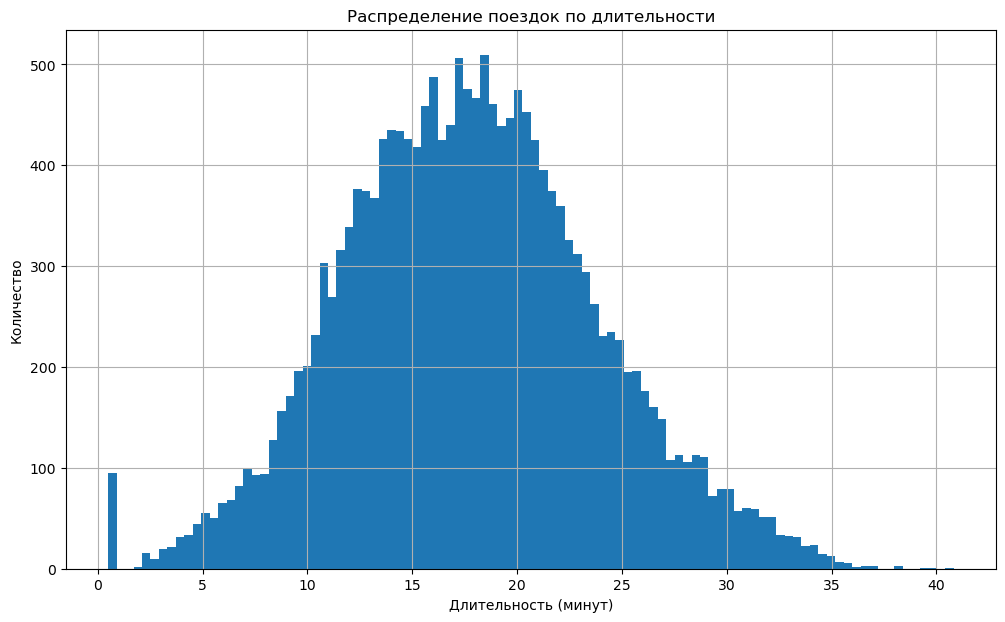

In [27]:
rides['duration'].hist(bins=100, figsize = (12, 7));
plt.title('Распределение поездок по длительности')
plt.ylabel('Количество')
plt.xlabel('Длительность (минут)')
plt.show()

Из гистограммы виден выброс в данных около 1 минуты.

In [28]:
for d in [4, 3, 2, 1]:
    c = rides[rides['duration'] < d]['duration'].count()
    print('Поездок длительностью, меньше', d, '-', c)

Поездок длительностью, меньше 4 - 183
Поездок длительностью, меньше 3 - 128
Поездок длительностью, меньше 2 - 95
Поездок длительностью, меньше 1 - 95


In [29]:
rides[(rides['duration'] < 1)].describe().T

,count,mean,min,25%,50%,75%,max,std
user_id,95.0,1092.210526,701.0,901.0,1069.0,1310.5,1524.0,244.028551
distance,95.0,5113.176549,4030.308008,4611.51082,5052.769411,5488.459099,7211.007745,658.254104
duration,95.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0
date,95,2021-07-01 13:53:41.052631552,2021-01-05 00:00:00,2021-03-16 00:00:00,2021-06-18 00:00:00,2021-10-18 12:00:00,2021-12-27 00:00:00,NaN
month,95.0,6.484211,1.0,3.0,6.0,10.0,12.0,3.709858


95 поездок имеют продолжительность ровно 0,5 минуты, при этом у них разные дистанции порядка 4000-7000 метров. 4 км за 30 секунд, это 480 км в час. Что-то тут явно не то.   
Некорректные данные по времени поездки можно скорректировать, если разделить дистанциию на скорость.  
Скорость посчитаем разными способами.

Первый: возьмем среднее от отношения дистанции к длительности в каждой конкретной поездке

In [30]:
(rides[(rides['duration'] > 1)]['distance'] / rides[(rides['duration'] > 1)]['duration']).mean()

176.91526708769788

Второй: разделим средние или медианные длительности на средние или медианные растояния  
Для этого возьмем статистически хактеристики датасета rides без строк с длительностью поездки меньше 1 минуты.

In [31]:
rides[(rides['duration'] > 1)].describe().T

,count,mean,min,25%,50%,75%,max,std
user_id,17973.0,841.551995,1.0,484.0,887.0,1213.0,1534.0,435.144929
distance,17973.0,3059.863833,0.855683,2538.839628,3129.029255,3762.636244,7066.003772,1108.814612
duration,17973.0,17.89648,2.035632,13.670439,17.714122,21.747016,40.823963,5.975424
date,17973,2021-06-30 19:41:36.745117696,2021-01-01 00:00:00,2021-04-02 00:00:00,2021-06-30 00:00:00,2021-09-28 00:00:00,2021-12-30 00:00:00,NaN
month,17973.0,6.486786,1.0,4.0,6.0,9.0,12.0,3.436024


In [32]:
print('Скорость самокатов по средним дистанциям и времени (метров в минуту): ', 3059.863833 / 17.89648)
print('Скорость самокатов по медианам дистанции и времени (метров в минуту): ', 3129.029255 / 17.714122)

Скорость самокатов по средним дистанциям и времени (метров в минуту):  170.97573561951847
Скорость самокатов по медианам дистанции и времени (метров в минуту):  176.6403807651319


В итоге возмьмем для корректировки - 176 метров в минуту

In [33]:
rides.loc[rides['duration'] < 1, 'duration'] = rides['distance'] / 176

Еще раз смоторим гистограмму длительности поездок

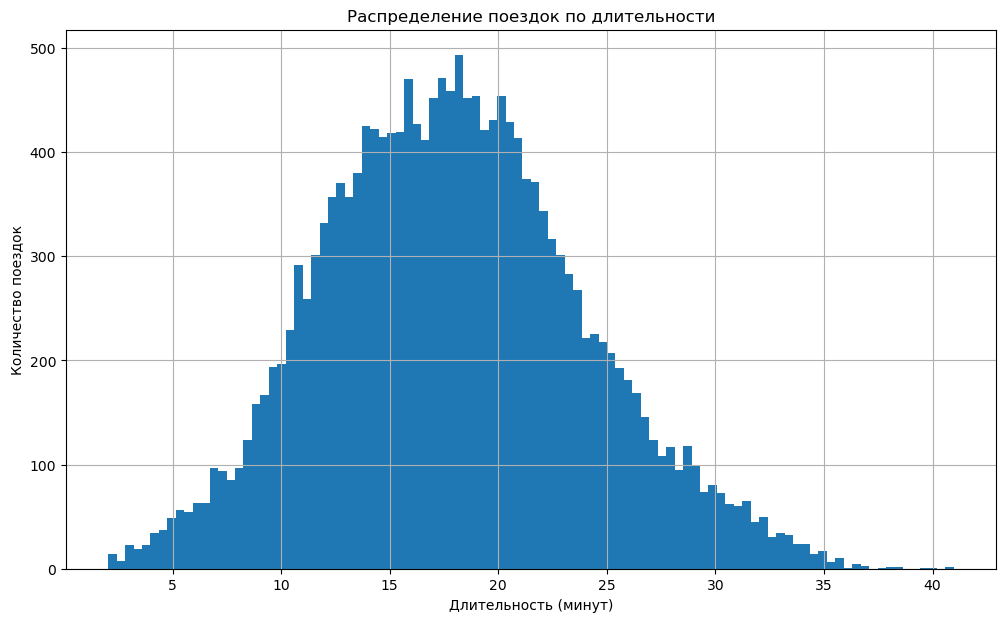

In [34]:
rides['duration'].hist(bins=100, figsize = (12, 7));
plt.title('Распределение поездок по длительности')
plt.ylabel('Количество поездок')
plt.xlabel('Длительность (минут)')
plt.show()

In [35]:
rides['duration'].describe()

count    18068.000000
mean        17.955136
std          6.020105
min          2.035632
25%         13.697117
50%         17.750643
75%         21.824361
max         40.971635
Name: duration, dtype: float64

Теперь выбросов в данных длительности одной поездки всех пользователей сервиса GoFast - нет

### Дистанция одной поездки

Оценим дистанцию одной поездки всех клиентов сервиса GoFast

In [36]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Средняя поездка составляет 3070 метра, а медианная - 3133 метра

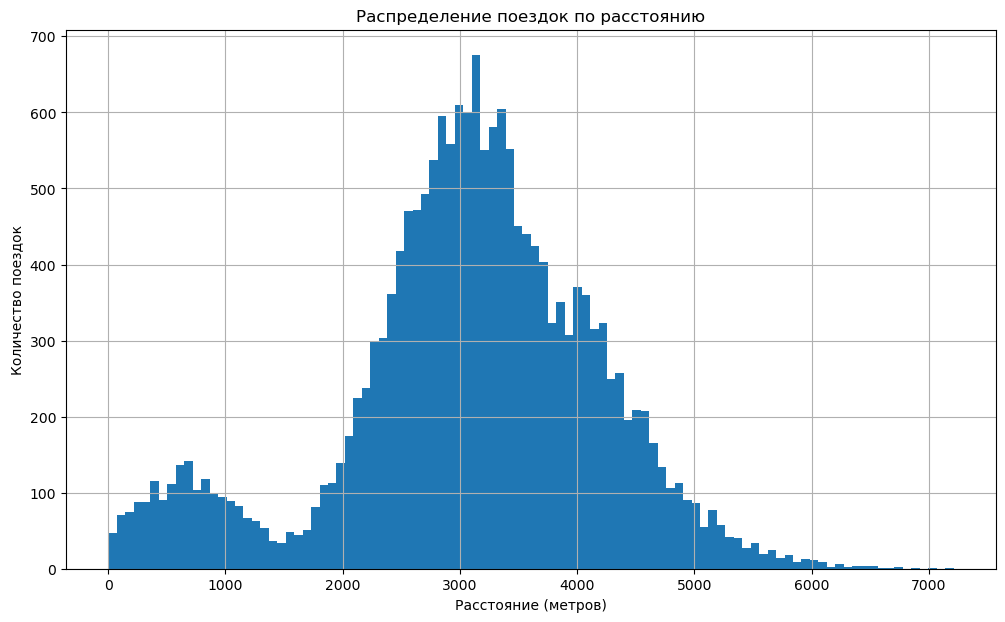

In [37]:
rides['distance'].hist(bins=100, figsize = (12, 7));
plt.title('Распределение поездок по расстоянию')
plt.ylabel('Количество поездок')
plt.xlabel('Расстояние (метров)')
plt.show()

Гисторграмма дистанции одной поездки всех клиентов сервиса GoFast показывает два пика: короткие поездки порядка 600 метров и основной около 3000 метров

Оценим "хвосты" в данных дистанции одной поездки всех клиентов

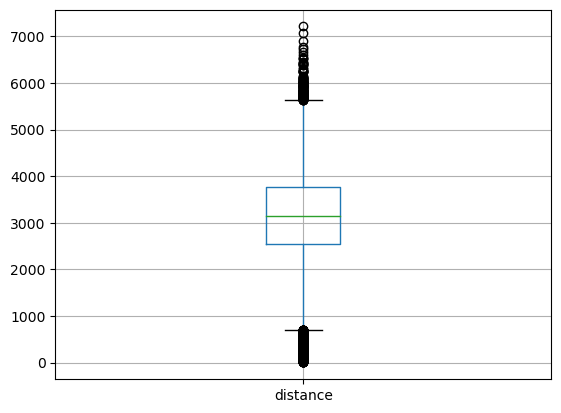

In [38]:
rides.boxplot(column='distance');

Оценим выбросы по процентилям 2% и 98%

In [39]:
np.quantile(rides.distance, 0.98)

5172.300006336312

In [40]:
rides[(rides['distance'] > 5172)]['distance'].count()

362

In [41]:
np.quantile(rides.distance, 0.02)

350.91245864442516

In [42]:
rides[(rides['distance'] < 350)]['distance'].count()

361

Оценим самые-самые концы "хвостов"

In [43]:
rides[(rides['distance'] < 100)].sort_values(by='distance').head(5)

,user_id,distance,duration,date,month
11555,1069,0.855683,10.001902,2021-01-31,1
9541,925,2.570787,3.011018,2021-10-19,10
13690,1223,4.329506,4.008958,2021-05-22,5
8658,861,6.784447,6.015656,2021-07-21,7
7841,796,7.097072,10.026614,2021-11-26,11


In [44]:
rides[(rides['distance'] > 5172)].sort_values(by='distance', ascending=False).head(5)

,user_id,distance,duration,date,month
16309,1411,7211.007745,40.971635,2021-04-15,4
16484,1422,7066.003772,23.619318,2021-02-12,2
15580,1361,6908.491343,23.816983,2021-03-27,3
17171,1471,6760.940067,32.043760,2021-08-03,8
17242,1477,6724.932981,38.209846,2021-01-12,1


Конечно, поездка на 0.8 метра за 10 минут выглядит совсем подозрительно, как и другие поездки на несколько метров, но почему именно такие данные в датасете - сказать сложно. Самое вероятное: какието технические неполадки самоката, которые клиенты пытались решить. Так как тарификация в сервисе GoFast все равно идет по времени, то отбрасывать короткие по расстоянию поездки не стоит.

***Промежуточный итог***  
Провели предварительную обработку данных. Преобразовали колонку data в тип DateTime. Убрали 31 дубликат. Провели анализ распределения данных о клиентах сервиса по географии, возрастам, типе подписке - тут корректировка не потребовалась. Данные о поездках проанализировали по длительности и растоянию. Скорректировали выбросы в длительности поездок. 

## Шаг 4. Объединение данных

Объединим даныне в один датасет. Исходным датасетом станет rides, к которому справа присоединим датасет user по колонке user_id, затем присоединим датасет subscriptions по колонке subscription_type

In [45]:
data = rides.merge(users, on = 'user_id', how='right')

In [46]:
data = data.merge(subscriptions, on = 'subscription_type', how='right')

Проверяем полученный результирующий датасет

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


In [48]:
len(rides)

18068

In [49]:
data.duplicated().sum()

0

Размерность результирующего датасета соответствует первому исходному датасету rides - 18068 строк, пропусков - нет, дубликатов - нет.

In [50]:
data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Выделим поездки клиентов с подпиской и без в два разных датасета:

In [51]:
data_free = data[data['subscription_type'] == 'free']

In [52]:
data_subs = data[data['subscription_type'] == 'ultra']

Сбрасываем индексы в новых датасетах и проверямм даннные

In [53]:
data_free = data_free.reset_index()
data_free.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11568 entries, 0 to 11567
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              11568 non-null  int64         
 1   user_id            11568 non-null  int64         
 2   distance           11568 non-null  float64       
 3   duration           11568 non-null  float64       
 4   date               11568 non-null  datetime64[ns]
 5   month              11568 non-null  int32         
 6   name               11568 non-null  object        
 7   age                11568 non-null  int64         
 8   city               11568 non-null  object        
 9   subscription_type  11568 non-null  object        
 10  minute_price       11568 non-null  int64         
 11  start_ride_price   11568 non-null  int64         
 12  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(6), object(

In [54]:
data_free.head()

,index,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [55]:
data_subs = data_subs.reset_index()
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              6500 non-null   int64         
 1   user_id            6500 non-null   int64         
 2   distance           6500 non-null   float64       
 3   duration           6500 non-null   float64       
 4   date               6500 non-null   datetime64[ns]
 5   month              6500 non-null   int32         
 6   name               6500 non-null   object        
 7   age                6500 non-null   int64         
 8   city               6500 non-null   object        
 9   subscription_type  6500 non-null   object        
 10  minute_price       6500 non-null   int64         
 11  start_ride_price   6500 non-null   int64         
 12  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(6), object(3)

In [56]:
data_subs.head()

,index,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,11568,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,11569,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,11570,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,11571,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,11572,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


В дальнейшем учитываем, что в датасете 6500 записей поездок клиентов с подпиской и почти в 2 раза больше - 11568 - поездок клиентов без подписки

Визуализируем информацию по полученным датасетм клиентов с подпиской и без 

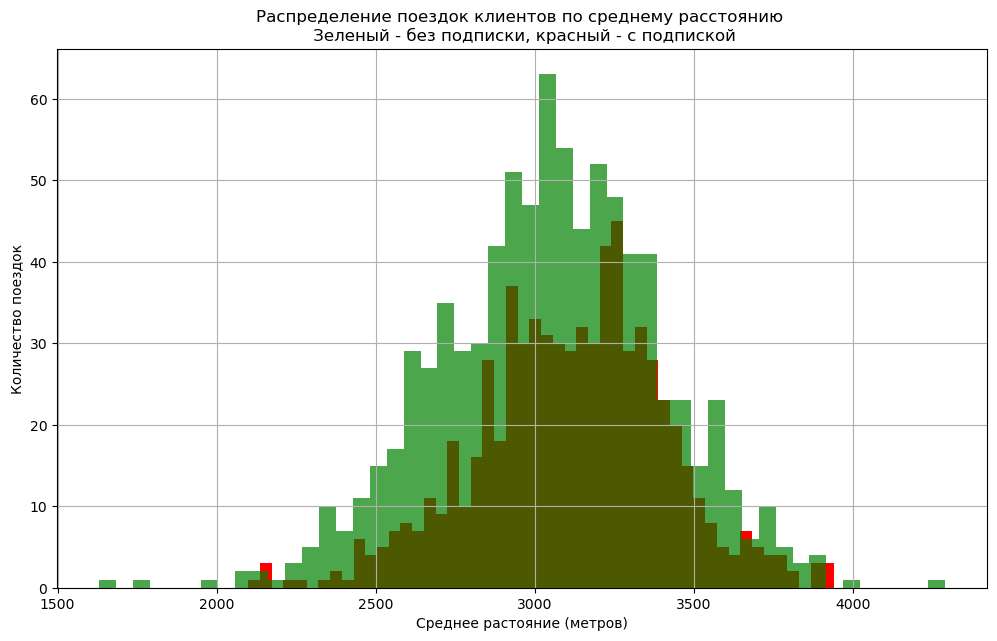

In [57]:
data_subs.groupby('user_id')['distance'].mean().hist(bins=50, color='red', figsize = (12, 7));
data_free.groupby('user_id')['distance'].mean().hist(bins=50, color='green', alpha=0.7);
plt.title('Распределение поездок клиентов по среднему расстоянию \n Зеленый - без подписки, красный - с подпиской')
plt.ylabel('Количество поездок')
plt.xlabel('Среднее растояние (метров)')
plt.show()

По гистограмме можно сказать, что чаще всего клиенты с подпиской за одну поездку проезжают около 3300 метров, а без подписки - около 3000 метров

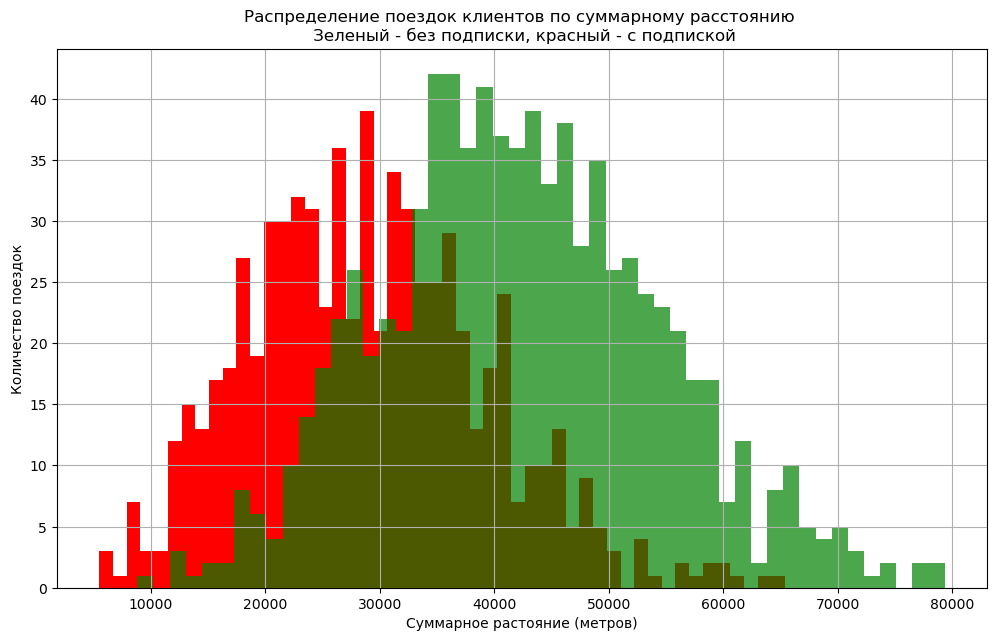

In [58]:
data_subs.groupby('user_id')['distance'].sum().hist(bins=50, color='red', figsize = (12, 7));
data_free.groupby('user_id')['distance'].sum().hist(bins=50, color='green', alpha=0.7);
plt.title('Распределение поездок клиентов по суммарному расстоянию \n Зеленый - без подписки, красный - с подпиской')
plt.ylabel('Количество поездок')
plt.xlabel('Суммарное растояние (метров)' )
plt.show()

По гистограмме можно сказать, что клиенты с подпиской в сумме проезжают меньше, чем клиенты без подписки. Что неувидительно, ведь последних почти в 2 раза больше

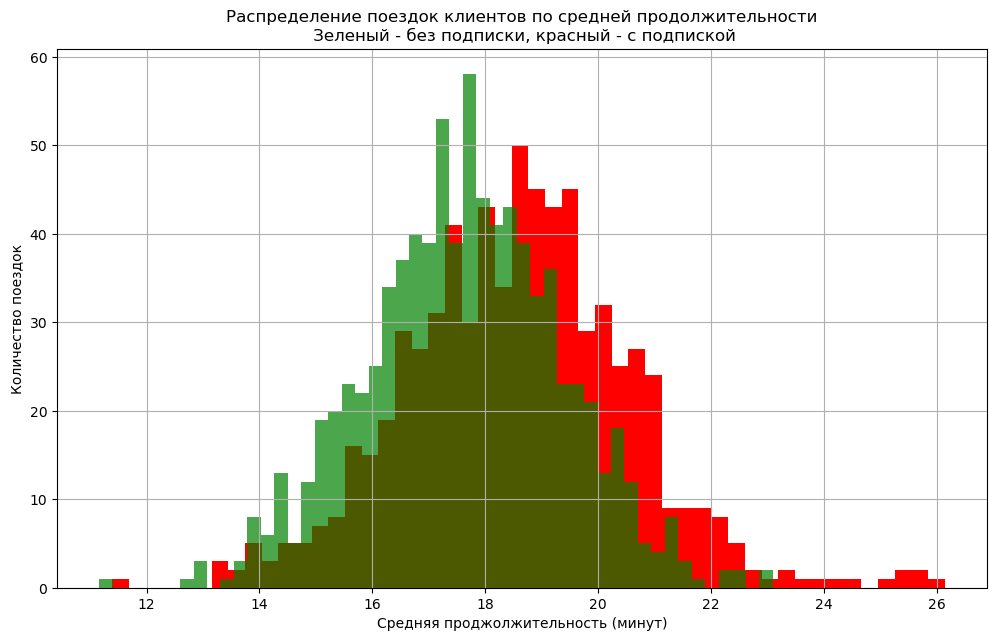

In [59]:
data_subs.groupby('user_id')['duration'].mean().hist(bins=50, color='red', figsize = (12, 7));
data_free.groupby('user_id')['duration'].mean().hist(bins=50, color='green', alpha=0.7);
plt.title('Распределение поездок клиентов по средней продолжительности\n Зеленый - без подписки, красный - с подпиской')
plt.ylabel('Количество поездок')
plt.xlabel('Средняя проджолжительность (минут)')
plt.show()

По гистограмме можно сказать, что чаще всего клиенты с подпиской в одну поездку катаются около 19 минут, а без подписки - около 17 минут

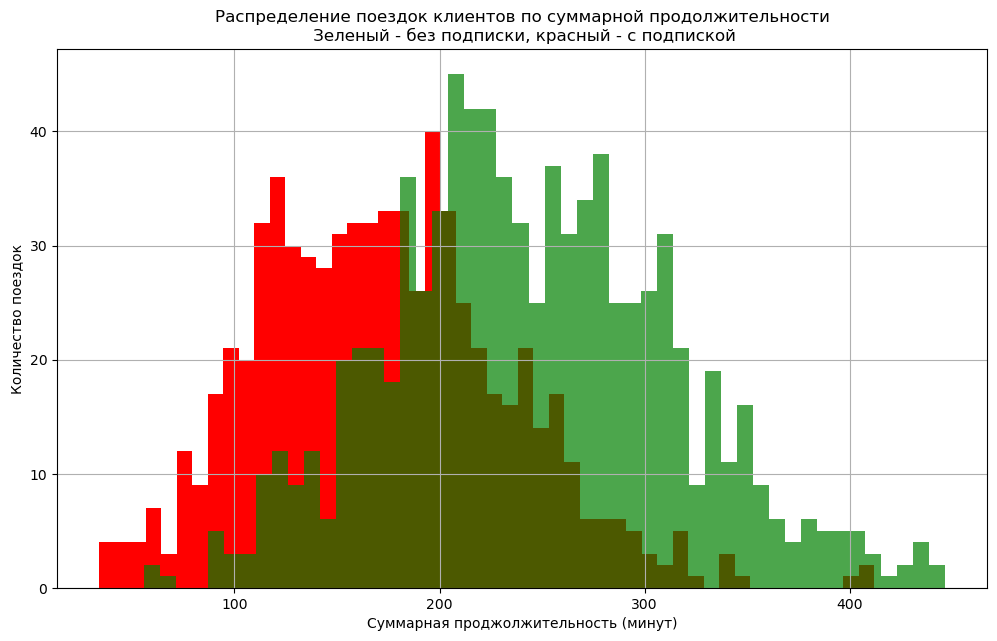

In [60]:
data_subs.groupby('user_id')['duration'].sum().hist(bins=50, color='red', figsize = (12, 7));
data_free.groupby('user_id')['duration'].sum().hist(bins=50, color='green', alpha=0.7);
plt.title('Распределение поездок клиентов по суммарной продолжительности\n Зеленый - без подписки, красный - с подпиской')
plt.ylabel('Количество поездок')
plt.xlabel('Суммарная проджолжительность (минут)')
plt.show()

По гистограмме можно сказать, что в суммарный накат по времи клиентов с подпиской меньше, чем клиенты без подписки. Что неувидительно, ведь последних почти в 2 раза больше

***Промежуточный итог***  
Свели данные из трех датасетов в один на основе датасета rides. Разделили этот итоговый датасет на два - поездки клиентов с подписками data_subs и поездки клиентов без подписок data_free. Стоит отметить, что в датасете поездок клиентов с подпиской почти в 2 раза меньше записей, чем без подписок. Представили визуализацию соотношения данных по средним и суммарным расстояниям и длительности поездок клиентов с подписками и без в гистограммах

## Шаг 5. Подсчёт выручки

Подсчитаем выручку, которую приносят клиенты сервису GoFast в месяц. По тарифам компании, стоимость поездки для клиентов записит от количества поездок и длительности конкретной поездки, и не зависит от пройденного расстония.

Сначала округлим все дробные минуты до большоего целого

In [61]:
data_free['dur_ceil'] = np.ceil(data_free['duration'])

Сформируем новый датасет revenue_free. Пока в нем будут месячные показатели клиентов без подписки - количество поездок, суммарная дистанция и суммарная длительность.

In [62]:
revenue_free = data_free.groupby(['user_id', 'month']).agg({'user_id' : ['count'], 'distance': ['sum'], 'dur_ceil' : ['sum']})
revenue_free.head(15)

user_id      distance dur_ceil
                count           sum      sum
user_id month                               
700     1           1   2515.690719     15.0
        2           5  13446.659764     89.0
        3           1   3798.334905     19.0
        4           1   2984.551206     16.0
        6           2   5927.650988     29.0
        7           2   4399.206279     21.0
        8           1   4071.654669     17.0
        10          2   6322.578618     44.0
        11          3   8735.782625     32.0
701     1           1   2676.472894     18.0
        2           2   5637.334007     27.0
        3           1   2802.021357     17.0
        4           1   3509.012965     14.0
        5           1   2465.852577     15.0
        6           2   4634.620760     26.0

Проверим данные по одному клиенту и одному месяцу

In [63]:
data_free[(data_free['user_id'] == 700) & (data_free['month'] == 6)]

,index,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,dur_ceil
8,8,700,3360.107141,16.765497,2021-06-12,6,Айдар,22,Омск,free,8,50,0,17.0
9,9,700,2567.543847,11.312160,2021-06-23,6,Айдар,22,Омск,free,8,50,0,12.0


У клиента с id 700 в июне было 2 поездки, общая дистанция - 5927 метров и фактической длительностию чуть больше 28 минут, но с округлениями все 29 - сходится!

Переименуем колонки для удобства

In [64]:
revenue_free.columns=['rides', 'dist_sum', 'dur_sum']

Посчитаем выручку за месяц, занеся ее в новую колонку revenue. Стоимость одной минуты поездки для клиентов без прописки - 8 рублей, стоимость старта — 50 рублей.

In [65]:
revenue_free['revenue'] = revenue_free['rides'] * 50 + revenue_free['dur_sum'] * 8

In [66]:
revenue_free.head()

rides      dist_sum  dur_sum  revenue
user_id month                                       
700     1          1   2515.690719     15.0    170.0
        2          5  13446.659764     89.0    962.0
        3          1   3798.334905     19.0    202.0
        4          1   2984.551206     16.0    178.0
        6          2   5927.650988     29.0    332.0

In [67]:
revenue_free.loc[700, 4]

rides          1.000000
dist_sum    2984.551206
dur_sum       16.000000
revenue      178.000000
Name: (700, 4), dtype: float64

Сделаем тоже самое для клиентов с подпиской, только стоимость одной минуты поездки — 6 рублей, стоимость старта — 0 рублей, подписка разово - 199 рублей

In [68]:
data_subs['dur_ceil'] = np.ceil(data_subs['duration'])

In [69]:
revenue_subs = data_subs.groupby(['user_id', 'month']).agg({'user_id' : ['count'], 'distance': ['sum'], 'dur_ceil' : ['sum']})
revenue_subs.head(15)

user_id      distance dur_ceil
                count           sum      sum
user_id month                               
1       1           2   7027.511294     42.0
        4           1    754.159807      7.0
        8           2   6723.470560     46.0
        10          2   5809.911100     32.0
        11          3   7003.499363     56.0
        12          2   6751.629942     28.0
2       3           3  10187.723006     63.0
        4           2   6164.381824     40.0
        6           1   3255.338202     14.0
        7           2   6780.722964     48.0
        8           1    923.007439      7.0
        10          1   2824.636598     19.0
        12          1   3828.248580     12.0
3       1           1   3061.777147     13.0
        2           2   5421.152016     39.0

In [70]:
revenue_subs.columns=['rides', 'dist_sum', 'dur_sum']

In [71]:
revenue_subs.head()

rides     dist_sum  dur_sum
user_id month                             
1       1          2  7027.511294     42.0
        4          1   754.159807      7.0
        8          2  6723.470560     46.0
        10         2  5809.911100     32.0
        11         3  7003.499363     56.0

In [72]:
revenue_subs['revenue'] = 199 + np.ceil(revenue_subs['dur_sum']) * 6

In [73]:
revenue_subs.head(15)

rides      dist_sum  dur_sum  revenue
user_id month                                       
1       1          2   7027.511294     42.0    451.0
        4          1    754.159807      7.0    241.0
        8          2   6723.470560     46.0    475.0
        10         2   5809.911100     32.0    391.0
        11         3   7003.499363     56.0    535.0
        12         2   6751.629942     28.0    367.0
2       3          3  10187.723006     63.0    577.0
        4          2   6164.381824     40.0    439.0
        6          1   3255.338202     14.0    283.0
        7          2   6780.722964     48.0    487.0
        8          1    923.007439      7.0    241.0
        10         1   2824.636598     19.0    313.0
        12         1   3828.248580     12.0    271.0
3       1          1   3061.777147     13.0    277.0
        2          2   5421.152016     39.0    433.0

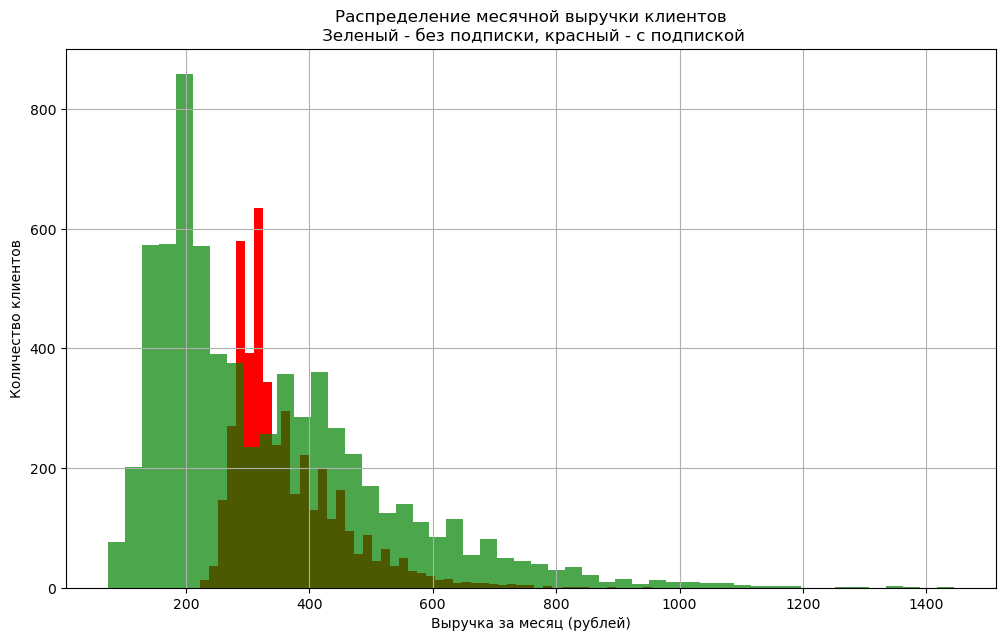

In [74]:
revenue_subs['revenue'].hist(bins=50, color='red', figsize = (12, 7));
revenue_free['revenue'].hist(bins=50, color='green', alpha=0.7);
plt.title('Распределение месячной выручки клиентов\n Зеленый - без подписки, красный - с подпиской')
plt.ylabel('Количество клиентов')
plt.xlabel('Выручка за месяц (рублей)')
plt.show()

Из гистограммы видно, что чаще всего клиенты с подпиской приносят в месяц выручку порядка 300 рублей, а без подписки - 200 рублей. 

In [75]:
revenue_subs.describe().T

,count,mean,std,min,25%,50%,75%,max
rides,4533.0,1.433929,0.696331,1.000000,1.000000,1.000000,2.000000,6.000000
dist_sum,4533.0,4467.327382,2353.168174,244.210438,2981.762521,3572.518224,5883.378452,20009.704886
dur_sum,4533.0,27.298698,14.710456,4.000000,17.000000,23.000000,35.000000,126.000000
revenue,4533.0,362.792191,88.262737,223.000000,301.000000,337.000000,409.000000,955.000000


In [76]:
revenue_free.describe().T

,count,mean,std,min,25%,50%,75%,max
rides,6798.0,1.701677,0.894871,1.000000,1.000000,1.000000,2.000000,7.000000
dist_sum,6798.0,5182.449164,3198.989334,2.570787,2952.361137,4324.635714,6861.657086,23429.487786
dur_sum,6798.0,30.844072,18.017690,3.000000,18.000000,26.000000,40.000000,143.000000
revenue,6798.0,331.836422,185.178910,74.000000,194.000000,274.000000,428.000000,1444.000000


Средние оценки выручки исходного датасета: 
- Средния месячная выручка от клиента без подписки - 328 рублей, медианная - 274.
- Средния месячнвя выручка от клиента с подпиской - 362 рубля, медианная - 337.

Средние показатели одной поездки клиентов с подпиской и без

In [77]:
ss = revenue_subs['rides'].sum()
fs = revenue_free['rides'].sum()
print('Для одной поездки клиентов с подпиской:',  \
      '\n Средняя дистанция:', round(revenue_subs['dist_sum'].sum() / ss ), 'метров', \
      '\n Среднее время:', round(revenue_subs['dur_sum'].sum() / ss), 'минут', \
      '\n Средняя выручка:', revenue_subs['revenue'].sum() /ss )
print('--------------')
print('Для одной поездки клиентов без подписки: ', \
      '\n Средняя дистанция:', round(revenue_free['dist_sum'].sum() / fs), 'метров', \
      '\n Среднее время:', round(revenue_free['dur_sum'].sum() / fs), 'минут', \
      '\n Средняя выручка:', revenue_free['revenue'].sum() / fs)


Для одной поездки клиентов с подпиской: 
 Средняя дистанция: 3115 метров 
 Среднее время: 19 минут 
 Средняя выручка: 253.0056923076923
--------------
Для одной поездки клиентов без подписки:  
 Средняя дистанция: 3045 метров 
 Среднее время: 18 минут 
 Средняя выручка: 195.00553250345783


Суммарные показатели всех поездок клиентов с подпиской и без

In [78]:
print('По подписке:\n Всего поездок', revenue_subs['rides'].sum(), \
      '\n Общая дистанция:', round(revenue_subs['dist_sum'].sum()), 'метров', \
      '\n Общее время:', round(revenue_subs['dur_sum'].sum()), 'минут', \
      '\n Суммарная выручка:', revenue_subs['revenue'].sum())
print('--------------')
print('Без подписки:\n всего поездок', revenue_free['rides'].sum(), \
      '\n Общая дистанция:', round(revenue_free['dist_sum'].sum()), 'метров', \
      '\n Общее время:', round(revenue_free['dur_sum'].sum()), 'минут', \
      '\n Суммарная выручка:', revenue_free['revenue'].sum())


По подписке:
 Всего поездок 6500 
 Общая дистанция: 20250395 метров 
 Общее время: 123745 минут 
 Суммарная выручка: 1644537.0
--------------
Без подписки:
 всего поездок 11568 
 Общая дистанция: 35230289 метров 
 Общее время: 209678 минут 
 Суммарная выручка: 2255824.0


***Промежуточный итог***  
По представленному датасету подсчитали выручку, которую приносят клиенты сервису GoFast в месяц. Средняя месячная выручка от клиента с подпиской больше, чем у клиентов без подписки: 362 протов 328 рублей. Средние параметры одной поездки у клиентов с подпиской также больше и по доходу, и по длительноти, и по расстоянию.  
Однако в сумме клиенты без подписки приносят гораздо больше выручки - 2.255 млн. против 1.644 млн. рублей. Это объяняется тем, что в представленном датасете количество поездок клиентов без подписки почти в два раза больше, чем у подписчиков. К сожалению сервиса самокатов, выручка не настолько же пропорционально больше, как количество поездок клиентов без подписки больше, чем поездок у подписчиков.

## Шаг 6. Проверка гипотез

### Тратят ли клиенты с подпиской больше времени на поездки ?

<i>Задание:
>Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки</i>

Имеем две независимые выборки - используем ttest_ind. Нулевая гипотеза - клиенты с подпиской тратят столько же или больше времени на поездки, чем клиенты без подписки. Альтернативная гипотеза - клиенты с подпиской тратят меньше времени на поездки, чем клиенты без подписки - alternative='less'

In [79]:
st.ttest_ind(data_subs['duration'], data_free['duration'], alternative = 'less', equal_var=False)

TtestResult(statistic=10.16191118117438, pvalue=1.0, df=14754.565197597509)

pvalue = 1, то нулевая гипотеза **не отвергается**, то есть клиенты с подпиской тратят больше времени на поездки, чем клинеты без подписки

Имеем две независимые выборки - используем ttest_ind. Нулевая гипотеза - клиенты с подпиской тратят времени на поездки не больше, то есть ровно или меньше, чем клиенты без подписки. Альтернативная гипотеза - клиенты с подпиской тратят больше времени на поездки, чем клиенты без подписки - alternative='greater'

In [80]:
st.ttest_ind(data_subs['duration'], data_free['duration'], alternative = 'greater',)

TtestResult(statistic=9.848174002221908, pvalue=3.983961504905613e-23, df=18066.0)

pvalue много меньше 0.01, то нулевая гипотеза отвергается, принимается альтернативная гипотеза, что клиенты с подпиской тратят больше времени на поездки, чем клинеты без подписки

###  У клиентов с подпиской растояние поездки меньше 3130 м ?

<i>Задание:
>Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров? Проверьте гипотезу и сделайте выводы. </i>

Имеем одну выборку, которую надо сравнить с заданным числом - используем ttest_1samp.  
Нулевая гипотеза - клиенты с подпиской проезжают за одну поездку ровно или меньше 3130 метров. Альтернативная гипотеза - клиенты с подпиской проезжают за одну поездку больше 3130: alternative = 'greater'

In [81]:
st.ttest_1samp(data_subs['distance'], 3130, alternative = 'greater')

TtestResult(statistic=-1.402123166869486, pvalue=0.9195368847849785, df=6499)

pvalue=0.92 - нулевая гипотеза **не отвергается**. Причем вероятность, что клиент с подпиской проедет за одну поездку меньше 3130 метров очень высока - 92%

Говорить, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров, с абсолютной уверенностью - нельзя. Все-таки таки есть вероятность в 8%, что поездка будет больше 3130 метров.

Для интереса, проведем такую же проверку гипотезы для клиентов без подписки

In [82]:
st.ttest_1samp(data_free['distance'], 3130, alternative = 'greater')

TtestResult(statistic=-7.293424308076774, pvalue=0.999999999999839, df=11567)

pvalue почти 1 - нулевая гипотеза **не отвергается**. Причем вероятность, что клиент без подпиской проедет за одну поездку меньше 3130 метров выше, чем у клиентов с подпиской и почти равна 100%

Ранее получили среднее расстояние одной поездки клиентов с подпиской 3115 метров, а без подписки 3045 метров - то есть сходится.

###  Помесячная выручка от клиентов с подпиской больше, чем без подписки ?

<i>Задание:
>Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки</i>

Имеем две независимые выборки - используем ttest_ind  
Нулевая гипотеза - клиенты с подпиской дают равную или большую помесячную выручку, чем пользователи без подписки. Альтернативная гипотеза - клиенты с подпиской дают меньшую помесячную выручку: alternative = 'less'

In [83]:
st.ttest_ind(revenue_subs['revenue'], revenue_free['revenue'], alternative = 'less', equal_var=False)

TtestResult(statistic=11.903521660007314, pvalue=1.0, df=10405.869482111148)

pvalue = 1, то нулевая гипотеза **не отвергается**, то есть клиенты с подпиской дают большую помесячную выручку, чем клиенты  без подписки

Имеем две независимые выборки - используем ttest_ind. Нулевая гипотеза - клиенты с подпиской дают месячную выручкук не больше, то есть ровно или меньше, чем клиенты без подписки. Альтернативная гипотеза - клиенты с подпиской дают месячную выручку больше, чем клиенты без подписки - alternative='greater'

In [84]:
st.ttest_ind(revenue_subs['revenue'], revenue_free['revenue'], alternative = 'greater', equal_var=False)

TtestResult(statistic=11.903521660007314, pvalue=9.211390180375745e-33, df=10405.869482111148)

pvalue много меньше 0.01, то нулевая гипотеза отвергается, принимается альтернативная гипотеза, что клиенты с подпиской дают выручку больше, чем клинеты без подписки

### Задание 6.4

>_Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?_

Для проверки гипозы "стало ли количество обращений после обновления сервера меньше, чем до обновления" нужно применить t-тест для двух зависимых выборок - ttest_rel

***Промежуточный итог***  
В этои разделе провериили три гипотезы.
- Гипотеза, что клиенты с подпиской тратят больше времени на поездки ***не была отвергнута***
- Гипотеза, что у клиентов с подпиской расстояние одной поездки меньше 3130 м ***не была отвергнута***
- Гипотеза, что помесячная выручка от клиентов с подпиской больше, чем без подписки ***не была отвергнута***

## Доп задание. Распределения

### Задание про промокоды

> _Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов  
Подсказка  
Нужно использовать биномиальное распределение, которое описывает указанную ситуацию. Затем подобрать подходящее значение параметра N для заданного параметра p=0.1 с помощью графиков и метода cdf()_
</i>

Для биномиального распределения используем данные: вероятность p = 0.1, количество положительнуых исходов k = 100, N - количество промокодов, которое мы задаем в цикле. Грубая прикидка дает, что N должно быть +/-1000 (k / p).  

_Метод cdf() возвращает вероятность, что случайная величина примет значение, меньшее заданного аргумента_

In [85]:
prom = pd.Series()
for n in range(800, 1300, 20):
    prom.loc[n] = st.binom.cdf(100, n, 0.1)
    print('При рассылке', n, 'промокодов вероятность получить меньше 100 подписок: ', prom[n])    

При рассылке 800 промокодов вероятность получить меньше 100 подписок:  0.9905659247601779
При рассылке 820 промокодов вероятность получить меньше 100 подписок:  0.9822513618746853
При рассылке 840 промокодов вероятность получить меньше 100 подписок:  0.9686606306207628
При рассылке 860 промокодов вероятность получить меньше 100 подписок:  0.9478553976428736
При рассылке 880 промокодов вероятность получить меньше 100 подписок:  0.9179310083742142
При рассылке 900 промокодов вероятность получить меньше 100 подписок:  0.8773710469953703
При рассылке 920 промокодов вероятность получить меньше 100 подписок:  0.8254198982189033
При рассылке 940 промокодов вероятность получить меньше 100 подписок:  0.7623762164812298
При рассылке 960 промокодов вероятность получить меньше 100 подписок:  0.6897179458849694
При рассылке 980 промокодов вероятность получить меньше 100 подписок:  0.6100093187661111
При рассылке 1000 промокодов вероятность получить меньше 100 подписок:  0.5265990812951653
При рассы

Чем больше промокодов, тем меньше вероятность не выполнить план - похоже на правду

Построим график функции распределения вероятности не выполнить план

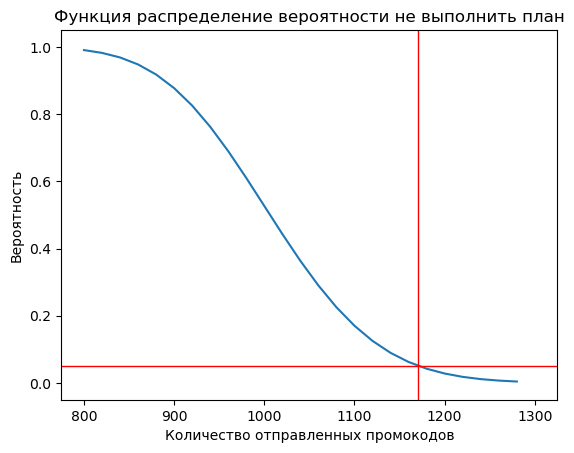

In [86]:
prom.plot();
plt.title('Функция распределение вероятности не выполнить план')
plt.ylabel('Вероятность')
plt.xlabel('Количество отправленных промокодов')
plt.axline((800, 0.05), (1300, 0.05), linewidth=1, color='r') 
plt.axline((1170, 0), (1170, 1), linewidth=1, color='r') 
plt.show()

***Вывод***  
Надо разослать минимум 1170 промокодов, чтобы вероятнность не выполнить план "как минимум 100 существующих клиентов продлили подписку" была менее 5%

### Задание про push-уведомления

> _Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей_

Аппроксимируем биноминальное распределение, для которого задано p=0.4 и n=1000000, нормальным распределением.  
Вычислим параметры нормального распределения:

In [87]:
p = 0.4
n = 1000000

nu = n * p
sigma = np.sqrt(n * p * (1 - p))

Оценим вероятность, что из 1 млн уведомлений их откроют не более 399500 пользователей, используя функцию cdf()

In [88]:
st.norm(nu, sigma).cdf(399500)

0.15371708296369768

Построим график функции распределение вероятности открытия push-уведомления

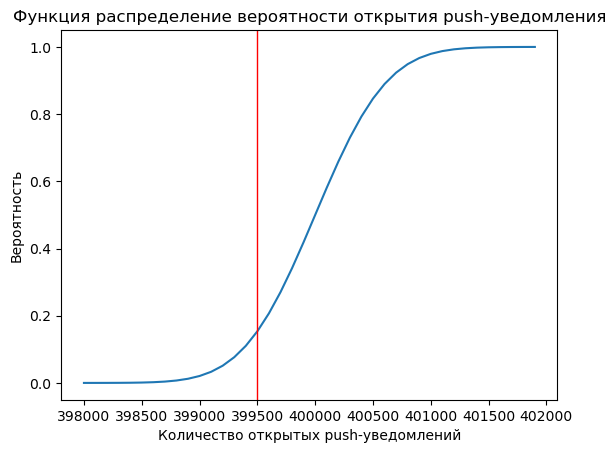

In [89]:
x_axis = np.arange(398000, 402000, 100)
plt.plot(x_axis, st.norm.cdf(x_axis, nu, sigma))
plt.title('Функция распределение вероятности открытия push-уведомления')
plt.ylabel('Вероятность')
plt.xlabel('Количество открытых push-уведомлений')
plt.axline((399500, 0), (399500, 1), linewidth=1, color='r') 
plt.show()  

***Вывод***  
Вероятность, что из 1 млн рассылок, уведомление откроют не более 399500 пользователей - 15%

## Основной вывод

Провели исследование для сервиса аренды самокатов GoFast. Были передоставленные три датасета о пользователях из разных городов, их поездках, а также типе подписки. В ходе предобработки данных были отброшены дубли, внесены небольшие корректировки по длительности поездок, объеденены датасеты. Затем все данные были разделены на два датасета - поездки клиентов с подпиской и клиентов без подписки. Исследование состояло в сравнении двух типов клиентов между собой.

По итогам исследоваия гипотезы, что клиенты с подпиской тратят больше времени на поездки, расстояние их поездок меньше 3130 метров и помесячная выручка от таких клиентов больше - не были отвергнуты.  

В целом можно дать рекомендацию: больше уделять внимания клиентам с подписками, так как они более эффективны. Вот бы всех клиентов перевести на подписку!